In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scvelo as scv
import scanpy as sc
from skimage.draw import polygon
from shapely.geometry import Polygon
import imageio
import tifffile
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import linregress
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.signal as signal
import peakutils
import seaborn as sns
import sklearn
import shapely
import os

# Load GCaMP Mean Intensity Data

In [4]:
mean_intensities_np = np.load('mean_intensities_SMAD.npy')
cell_ids = np.load("cell_ids_SMAD.npy")
adata_mean_intensities = ad.AnnData(
    X=mean_intensities_np,
    obs=[str(i) for i in range(1, 41)],
    var=cell_ids
)
adata_mean_intensities.var_names = adata_mean_intensities.var[0]
adata_mean_intensities.var.columns = ['cell_id']
adata_mean_intensities.obs.columns = ['time_point']

In [5]:
adata_mean_intensities

AnnData object with n_obs × n_vars = 40 × 155237
    obs: 'time_point'
    var: 'cell_id'

In [7]:
cell_types = pd.read_csv("cell_annotations_SMAD.csv")
cell_types.index = cell_types['Cell_ID']

adata_mean_intensities = adata_mean_intensities[:, cell_types['Cell_ID']]
adata_mean_intensities.var['cell_type'] = cell_types['cell_type_final']

# Call Peaks and Calculate Metrics

In [9]:
cell_medians = np.median(adata_mean_intensities.X, axis=0)
adata_mean_intensities.var['Median'] = cell_medians
adata_mean_intensities.var['Median_z'] = (cell_medians - cell_medians.mean()) / cell_medians.std()

q25 = np.percentile(adata_mean_intensities.X, 25, axis=0)
adata_mean_intensities.var['q25'] = q25
adata_mean_intensities.var['q25_z'] = (q25 - q25.mean()) / q25.std()

cell_means = np.mean(adata_mean_intensities.X, axis=0)
adata_mean_intensities.var['Mean'] = cell_means
adata_mean_intensities.var['Mean_z'] = (cell_means - cell_means.mean()) / cell_means.std()

var_sds = np.std(adata_mean_intensities.X, axis=0)
adata_mean_intensities.var['SD'] = var_sds
adata_mean_intensities.var['SD_log'] = np.log1p(var_sds)
adata_mean_intensities.var['SD_z'] = (var_sds - var_sds.mean()) / var_sds.std()

cell_min = np.min(adata_mean_intensities.X, axis=0)
adata_mean_intensities.var['min'] = cell_min
adata_mean_intensities.var['min_z'] = (cell_min - cell_min.mean()) / cell_min.std()

In [10]:
def count_peaks(cell_values, median, the_min):
    raw_threshold1 = 1.5 * median
    threshold1 = max(raw_threshold1, 3)
    raw_threshold2 = 2.0 * median
    threshold2 = max(raw_threshold2, 5)
    raw_threshold3 = 1.4 * median
    threshold3 = max(raw_threshold3, 3)
    
    raw_threshold4 = 2 * the_min
    threshold4 = max(raw_threshold4, 5)
    raw_threshold5 = 2.5 * the_min
    threshold5 = max(raw_threshold5, 6)
    raw_threshold6 = 1.8 * the_min
    threshold6 = max(raw_threshold6, 5)
    
    raw_threshold7 = 1.2 * median
    threshold7 = max(raw_threshold7, 3)
    
    peaks = 0
    n = len(cell_values)
    i = 0

    while i < n:
        val = cell_values[i]
        if val > threshold1:
            start = i
            while i < n and cell_values[i] > threshold3:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
            elif run_max > threshold2 and end == n:
                peaks += 1
        elif val > threshold4:
            start = i
            while i < n and cell_values[i] > threshold6:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
            elif run_max > threshold5 and end == n:
                peaks += 1
        elif val > threshold7:
            start = i
            while i < n and cell_values[i] > threshold7:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 3:
                peaks += 1
            else:
                i = start +1
        else:
            i += 1
    return peaks
data = adata_mean_intensities.X.T
q25 = np.percentile(adata_mean_intensities.X, 25, axis=0)
cell_min = np.min(adata_mean_intensities.X, axis=0)
peak_counts_min = [count_peaks(data[i, :], q25[i], cell_min[i]) for i in range(data.shape[0])]
peak_counts_min = np.array(peak_counts_min)
adata_mean_intensities.var["Peak_Counts"] = peak_counts_min
adata_mean_intensities.var["Peak_Counts_z"] = (peak_counts_min - peak_counts_min.mean()) / peak_counts_min.std()

In [11]:
data = adata_mean_intensities.X.T
medians = np.median(data, axis=1)
q25 = np.percentile(adata_mean_intensities.X, 25, axis=0)
cell_min = np.min(adata_mean_intensities.X, axis=0)
auc_above_median = []
for i in range(data.shape[0]):
    above_median = data[i, :] - medians[i]
    above_median[above_median < 0] = 0
    auc = np.sum(above_median)
    auc_above_median.append(auc)
auc_above_median = np.array(auc_above_median)
adata_mean_intensities.var["AUC_above_median"] = auc_above_median
adata_mean_intensities.var["AUC_above_median_log"] = np.log1p(auc_above_median)
adata_mean_intensities.var["AUC_above_median_z"] = (auc_above_median - auc_above_median.mean()) / auc_above_median.std()

auc_above_q25 = []
for i in range(data.shape[0]):
    above_q25 = data[i, :] - q25[i]
    above_q25[above_q25 < 0] = 0
    auc = np.sum(above_q25)
    auc_above_q25.append(auc)
auc_above_q25 = np.array(auc_above_q25)
adata_mean_intensities.var["AUC_above_q25"] = auc_above_q25
adata_mean_intensities.var["AUC_above_q25_log"] = np.log1p(auc_above_q25)
adata_mean_intensities.var["AUC_above_q25_z"] = (auc_above_q25 - auc_above_q25.mean()) / auc_above_q25.std()

auc_above_min = []
for i in range(data.shape[0]):
    above_min = data[i, :] - cell_min[i]
    above_min[above_min < 0] = 0
    auc = np.sum(above_min)
    auc_above_min.append(auc)
auc_above_min = np.array(auc_above_min)
adata_mean_intensities.var["AUC_above_min"] = auc_above_min
adata_mean_intensities.var["AUC_above_min_log"] = np.log1p(auc_above_min)
adata_mean_intensities.var["AUC_above_min_z"] = (auc_above_min - auc_above_min.mean()) / auc_above_min.std()


In [12]:
def calculate_peak_amplitude_fold(cell_values, median, the_min):
    raw_threshold1 = 1.5 * median
    threshold1 = max(raw_threshold1, 3)
    threshold2 = 2.0 * median
    threshold2 = max(threshold2, 5)
    raw_threshold3 = 1.4 * median
    raw_threshold3 = max(raw_threshold3, 3)
    
    raw_threshold4 = 2 * the_min
    threshold4 = max(raw_threshold4, 5)
    raw_threshold5 = 2.5 * the_min
    threshold5 = max(raw_threshold5, 6)
    raw_threshold6 = 1.8 * the_min
    threshold6 = max(raw_threshold6, 5)
    
    raw_threshold7 = 1.2 * median
    threshold7 = max(raw_threshold7, 3)
    
    peaks = 0
    n = len(cell_values)
    i = 0
    amplitude = 0

    while i < n:
        val = cell_values[i]
        if val > threshold1:
            start = i
            while i < n and cell_values[i] > raw_threshold3:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
                amplitude = max(amplitude,run_max/median)
            elif run_max > threshold2 and end == n:
                peaks += 1
                amplitude = max(amplitude,run_max/median)
        elif val > threshold4:
            start = i
            while i < n and cell_values[i] > threshold6:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
                amplitude = max(amplitude,run_max/the_min)
            elif run_max > threshold5 and end == n:
                peaks += 1
                amplitude = max(amplitude,run_max/the_min)
        elif val > threshold7:
            start = i
            while i < n and cell_values[i] > threshold7:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 3:
                peaks += 1
                amplitude = max(amplitude,run_max/median)
            else:
                i = start +1
        else:
            i += 1
    return amplitude

data = adata_mean_intensities.X.T
medians = np.median(data, axis=1)
q25 = np.percentile(adata_mean_intensities.X, 25, axis=0)
cell_min = np.min(adata_mean_intensities.X, axis=0)
peak_amplitudes_fold = [calculate_peak_amplitude_fold(data[i, :], q25[i], cell_min[i]) for i in range(data.shape[0])]

peak_amplitudes_fold = np.array(peak_amplitudes_fold)
adata_mean_intensities.var["Peak_Amplitude_fold"] = peak_amplitudes_fold
adata_mean_intensities.var["Peak_Amplitude_fold_log"] = np.log1p(peak_amplitudes_fold)
adata_mean_intensities.var["Peak_Amplitude_fold_z"] = (peak_amplitudes_fold - peak_amplitudes_fold.mean()) / peak_amplitudes_fold.std()


In [13]:
def calculate_peak_amplitude(cell_values, median, the_min):
    raw_threshold1 = 1.5 * median
    threshold1 = max(raw_threshold1, 3)
    threshold2 = 2.0 * median
    threshold2 = max(threshold2, 5)
    raw_threshold3 = 1.4 * median
    raw_threshold3 = max(raw_threshold3, 3)
    
    raw_threshold4 = 2 * the_min
    threshold4 = max(raw_threshold4, 5)
    raw_threshold5 = 2.5 * the_min
    threshold5 = max(raw_threshold5, 6)
    raw_threshold6 = 1.8 * the_min
    threshold6 = max(raw_threshold6, 5)
    
    raw_threshold7 = 1.2 * median
    threshold7 = max(raw_threshold7, 3)
    
    peaks = 0
    n = len(cell_values)
    i = 0
    amplitude = 0

    while i < n:
        val = cell_values[i]
        if val > threshold1:
            start = i
            while i < n and cell_values[i] > raw_threshold3:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
                amplitude = max(amplitude,run_max-median)
            elif run_max > threshold2 and end == n:
                peaks += 1
                amplitude = max(amplitude,run_max-median)
        elif val > threshold4:
            start = i
            while i < n and cell_values[i] > threshold6:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
                amplitude = max(amplitude,run_max-the_min)
            elif run_max > threshold5 and end == n:
                peaks += 1
                amplitude = max(amplitude,run_max-the_min)
        elif val > threshold7:
            start = i
            while i < n and cell_values[i] > threshold7:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 3:
                peaks += 1
                amplitude = max(amplitude,run_max-median)
            else:
                i = start +1
        else:
            i += 1
    return amplitude

data = adata_mean_intensities.X.T
medians = np.median(data, axis=1)
q25 = np.percentile(adata_mean_intensities.X, 25, axis=0)
cell_min = np.min(adata_mean_intensities.X, axis=0)
peak_amplitudes = [calculate_peak_amplitude(data[i, :], q25[i],cell_min[i]) for i in range(data.shape[0])]

peak_amplitudes = np.array(peak_amplitudes)
adata_mean_intensities.var["Peak_Amplitude"] = peak_amplitudes
adata_mean_intensities.var["Peak_Amplitude_log"] = np.log1p(peak_amplitudes)
adata_mean_intensities.var["Peak_Amplitude_z"] = (peak_amplitudes - peak_amplitudes.mean()) / peak_amplitudes.std()


In [14]:
def peak_time(cell_values, median, the_min):
    raw_threshold1 = 1.5 * median
    threshold1 = max(raw_threshold1, 3)
    threshold2 = 2.0 * median
    threshold2 = max(threshold2, 5)
    raw_threshold3 = 1.4 * median
    raw_threshold3 = max(raw_threshold3, 3)
    
    raw_threshold4 = 2 * the_min
    threshold4 = max(raw_threshold4, 5)
    raw_threshold5 = 2.5 * the_min
    threshold5 = max(raw_threshold5, 6)
    raw_threshold6 = 1.8 * the_min
    threshold6 = max(raw_threshold6, 5)
    
    raw_threshold7 = 1.2 * median
    threshold7 = max(raw_threshold7, 3)
    
    peaks = 0
    n = len(cell_values)
    i = 0
    peak_times = []

    while i < n:
        val = cell_values[i]
        if val > threshold1:
            start = i
            while i < n and cell_values[i] > raw_threshold3:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
                if start == 0 and cell_values[start] == run_max:
                    peak_times.append(run_length*2)
                elif end < n:
                    peak_times.append(run_length)
                elif cell_values[end-1] == run_max:
                    peak_times.append(run_length*2)
                else:
                    peak_times.append(run_length)
            elif run_max > threshold2 and end == n:
                peaks += 1
                peak_times.append(run_length*2)
        elif val > threshold4:
            start = i
            while i < n and cell_values[i] > threshold6:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 2:
                peaks += 1
                if start == 0 and cell_values[start] == run_max:
                    peak_times.append(run_length*2)
                elif end < n:
                    peak_times.append(run_length)
                elif cell_values[end-1] == run_max:
                    peak_times.append(run_length*2)
                else:
                    peak_times.append(run_length)
            elif run_max > threshold5 and end == n:
                peaks += 1
                peak_times.append(run_length*2)
        elif val > threshold7:
            start = i
            while i < n and cell_values[i] > threshold7:
                i += 1
            end = i
            run_length = end - start
            run_max = cell_values[start:end].max()
            if run_length >= 3:
                peaks += 1
                if start == 0 and cell_values[start] == run_max:
                    peak_times.append(run_length*2)
                elif end < n:
                    peak_times.append(run_length)
                elif cell_values[end-1] == run_max:
                    peak_times.append(run_length*2)
                else:
                    peak_times.append(run_length)
            else:
                i = start +1
        else:
            i += 1
    if len(peak_times) == 0:
        peak_times = [0]
    peak_times = np.array(peak_times)
    return peak_times.mean()
data = adata_mean_intensities.X.T
q25 = np.percentile(adata_mean_intensities.X, 25, axis=0)
cell_min = np.min(adata_mean_intensities.X, axis=0)
peak_time = [peak_time(data[i, :], q25[i], cell_min[i]) for i in range(data.shape[0])]

peak_time = np.array(peak_time)
adata_mean_intensities.var["Peak_Duration"] = peak_time
adata_mean_intensities.var["Peak_Duration_z"] = (peak_time - peak_time.mean()) / peak_time.std()


In [17]:
adata_gcamp = adata_mean_intensities.var
adata_gcamp_active = adata_gcamp[adata_gcamp['Peak_Counts']>0]

In [19]:
adata_gcamp

,cell_id,cell_type,Median,Median_z,q25,q25_z,Mean,Mean_z,SD,SD_log,...,AUC_above_min_log,AUC_above_min_z,Peak_Amplitude_fold,Peak_Amplitude_fold_log,Peak_Amplitude_fold_z,Peak_Amplitude,Peak_Amplitude_log,Peak_Amplitude_z,Peak_Duration,Peak_Duration_z
hagbjphd-1,hagbjphd-1,Cycling Radial Glia,2.673913,-0.430630,2.576659,-0.401167,2.681178,-0.468878,0.155945,0.144919,...,2.675332,-0.559111,0.000000,0.000000,-0.509079,0.000000,0.000000,-0.414576,0.0,-0.450196
hldeboca-1,hldeboca-1,Excitatory Neurons,2.632399,-0.449828,2.485981,-0.444791,2.788084,-0.420347,0.510626,0.412524,...,3.283414,-0.005437,1.765664,1.017281,1.149706,1.903427,1.065892,0.427528,4.0,0.600424
godedlde-1,godedlde-1,Radial Glia,2.436722,-0.540317,2.325726,-0.521890,2.446473,-0.575424,0.186774,0.171239,...,2.975826,-0.327212,0.000000,0.000000,-0.509079,0.000000,0.000000,-0.414576,0.0,-0.450196
hjjhocal-1,hjjhocal-1,Excitatory Neurons,3.194181,-0.190036,3.096076,-0.151277,3.208457,-0.229517,0.165612,0.153247,...,2.465895,-0.684121,0.000000,0.000000,-0.509079,0.000000,0.000000,-0.414576,0.0,-0.450196
amkinlod-1,amkinlod-1,Excitatory Neurons,2.116279,-0.688502,1.971899,-0.692115,2.184690,-0.694262,0.330411,0.285488,...,3.049310,-0.259084,0.000000,0.000000,-0.509079,0.000000,0.000000,-0.414576,0.0,-0.450196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hdjppoap-1,hdjppoap-1,Inhibitory Neurons,2.714286,-0.411960,2.516129,-0.430288,3.125806,-0.267036,1.229514,0.801784,...,4.044667,1.381106,2.996337,1.385378,2.305884,5.023041,1.795592,1.807690,9.0,1.913699
kmhokcmj-1,kmhokcmj-1,Excitatory Neurons,5.526232,0.888400,4.170111,0.365438,6.274006,1.162108,2.279252,1.187615,...,4.730282,3.943848,2.425848,1.231349,1.769928,5.945946,1.938158,2.215997,19.0,4.540248
migcehko-1,migcehko-1,Neuronal Progenitors,1.990040,-0.746881,1.851594,-0.749994,1.973108,-0.790311,0.199535,0.181934,...,2.868668,-0.418003,0.000000,0.000000,-0.509079,0.000000,0.000000,-0.414576,0.0,-0.450196
gceceldn-1,gceceldn-1,Astrocytes,3.234317,-0.171476,3.083487,-0.157333,3.232380,-0.218657,0.196234,0.179179,...,3.099061,-0.210033,0.000000,0.000000,-0.509079,0.000000,0.000000,-0.414576,0.0,-0.450196


In [18]:
adata_gcamp_active

,cell_id,cell_type,Median,Median_z,q25,q25_z,Mean,Mean_z,SD,SD_log,...,AUC_above_min_log,AUC_above_min_z,Peak_Amplitude_fold,Peak_Amplitude_fold_log,Peak_Amplitude_fold_z,Peak_Amplitude,Peak_Amplitude_log,Peak_Amplitude_z,Peak_Duration,Peak_Duration_z
hldeboca-1,hldeboca-1,Excitatory Neurons,2.632399,-0.449828,2.485981,-0.444791,2.788084,-0.420347,0.510626,0.412524,...,3.283414,-0.005437,1.765664,1.017281,1.149706,1.903427,1.065892,0.427528,4.0,0.600424
nejnejeb-1,nejnejeb-1,Excitatory Neurons,2.470199,-0.524836,2.158940,-0.602130,2.498179,-0.551952,0.449857,0.371465,...,3.531412,0.336603,1.730061,1.004324,1.116259,1.576159,0.946300,0.282740,3.0,0.337769
nakcehej-1,nakcehej-1,Astrocytes,3.760720,0.071955,3.634220,0.107623,3.826201,0.050912,0.337927,0.291122,...,2.901365,-0.391324,1.358348,0.857961,0.767046,1.302316,0.833915,0.161587,3.0,0.337769
kcdlbpno-1,kcdlbpno-1,Neuronal Progenitors,3.896825,0.134895,3.800454,0.187597,3.992545,0.126425,0.302767,0.264491,...,3.038946,-0.268999,1.285800,0.826716,0.698889,1.086168,0.735329,0.065960,3.0,0.337769
efpfkcpf-1,efpfkcpf-1,Excitatory Neurons,3.206128,-0.184512,3.057103,-0.170027,3.864554,0.068323,1.352825,0.855617,...,3.917800,1.071106,2.533941,1.262414,1.871478,4.689415,1.738607,1.660089,6.5,1.257061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feekdkfg-1,feekdkfg-1,Excitatory Neurons,2.625598,-0.452972,2.451555,-0.461354,3.141268,-0.260018,1.096838,0.740430,...,3.802934,0.822413,2.382044,1.218480,1.728776,3.388158,1.478910,1.084394,11.0,2.439009
jmeebehp-1,jmeebehp-1,Excitatory Neurons,2.208243,-0.645975,2.045553,-0.656680,2.573210,-0.517891,1.175656,0.777330,...,3.374896,0.110980,3.220573,1.439971,2.516546,4.542299,1.712409,1.595003,8.0,1.651044
eadapedb-1,eadapedb-1,Excitatory Neurons,3.945809,0.157547,3.770231,0.173057,4.469147,0.342781,1.413412,0.881042,...,3.854871,0.931330,2.729398,1.316247,2.055104,6.520231,2.017597,2.470069,8.0,1.651044
hdjppoap-1,hdjppoap-1,Inhibitory Neurons,2.714286,-0.411960,2.516129,-0.430288,3.125806,-0.267036,1.229514,0.801784,...,4.044667,1.381106,2.996337,1.385378,2.305884,5.023041,1.795592,1.807690,9.0,1.913699


In [36]:
gcamp_features_raw = adata_mean_intensities.var[['cell_id','cell_type', 'Median','SD','Peak_Counts',
                                                 'AUC_above_median','AUC_above_q25','Peak_Amplitude_fold',
                                                 'Peak_Amplitude','Peak_Duration']]

# Check Example Cells

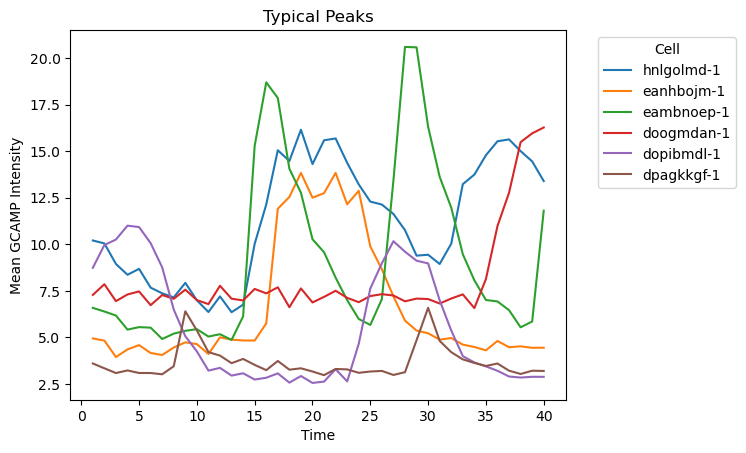

In [21]:
cell_id_list = ['hnlgolmd-1','eanhbojm-1','eambnoep-1','doogmdan-1',
                'dopibmdl-1','dpagkkgf-1']
adata_subset = adata_mean_intensities[:, cell_id_list].copy()
mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(6):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

plt.xlabel('Time')
plt.ylabel('Mean GCAMP Intensity')
plt.title('Typical Peaks')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [22]:
adata_subset.var[['cell_type','Peak_Counts','Peak_Amplitude','Peak_Amplitude_fold','Peak_Duration']]

,cell_type,Peak_Counts,Peak_Amplitude,Peak_Amplitude_fold,Peak_Duration
hnlgolmd-1,Excitatory Neurons,2,7.556259,1.878460,10.5
eanhbojm-1,Excitatory Neurons,1,9.358553,3.089351,13.0
eambnoep-1,Excitatory Neurons,3,15.060185,3.714981,7.0
doogmdan-1,Excitatory Neurons,1,9.280612,2.326417,10.0
dopibmdl-1,Excitatory Neurons,2,8.086667,3.773628,9.5
dpagkkgf-1,Excitatory Neurons,2,3.423723,2.081882,2.5


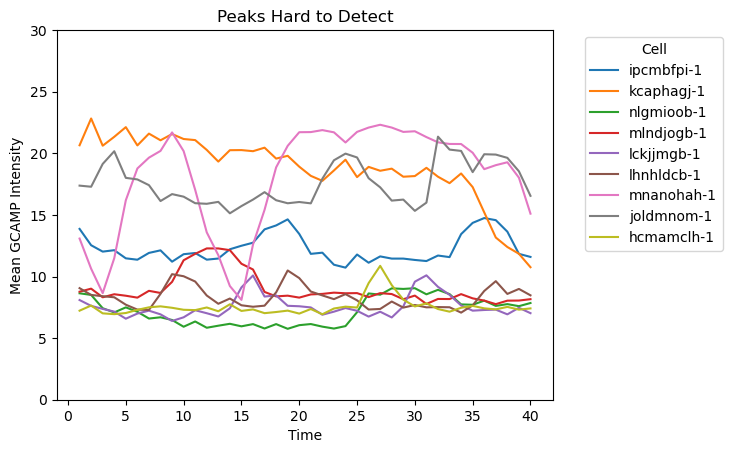

In [25]:
cell_id_list=['ipcmbfpi-1','kcaphagj-1','nlgmioob-1','mlndjogb-1','lckjjmgb-1','lhnhldcb-1',
             'mnanohah-1','joldmnom-1','hcmamclh-1']
adata_subset = adata_mean_intensities[:, cell_id_list].copy()
mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

plt.xlabel('Time')
plt.ylabel('Mean GCAMP Intensity')
plt.title('Peaks Hard to Detect')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 30)
plt.show()

In [26]:
adata_subset.var[['cell_type','Peak_Counts','Peak_Amplitude','Peak_Amplitude_fold','Peak_Duration']]

,cell_type,Peak_Counts,Peak_Amplitude,Peak_Amplitude_fold,Peak_Duration
ipcmbfpi-1,Radial Glia,2,3.286072,1.286757,3.0
kcaphagj-1,Excitatory Neurons,1,12.070746,2.122211,11.0
nlgmioob-1,Inhibitory Neurons,2,2.935363,1.480007,10.5
mlndjogb-1,Excitatory Neurons,1,4.009838,1.484783,7.0
lckjjmgb-1,Inhibitory Neurons,1,3.081776,1.439374,4.0
lhnhldcb-1,Excitatory Neurons,1,2.578542,1.338728,3.0
mnanohah-1,Excitatory Neurons,2,14.217014,2.754660,14.5
joldmnom-1,Excitatory Neurons,3,5.243090,1.325457,3.0
hcmamclh-1,Excitatory Neurons,1,3.643599,1.504431,3.0


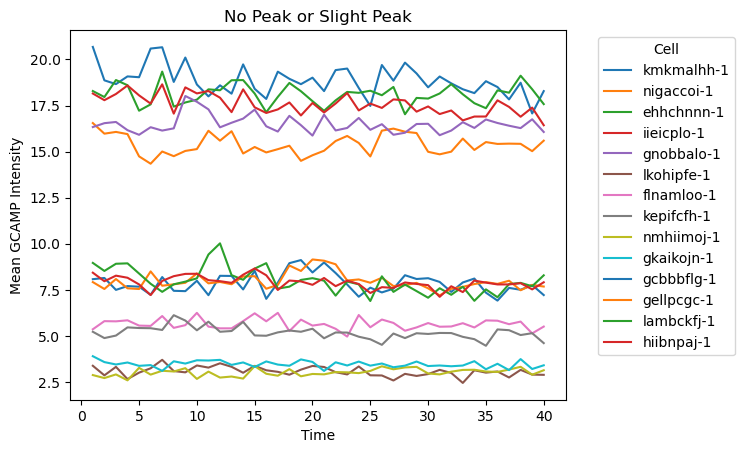

In [23]:
cell_id_list = ['kmkmalhh-1','nigaccoi-1','ehhchnnn-1','iieicplo-1','gnobbalo-1',
                'lkohipfe-1','flnamloo-1','kepifcfh-1','nmhiimoj-1','gkaikojn-1',
                'gcbbbflg-1','gellpcgc-1','lambckfj-1','hiibnpaj-1']
adata_subset = adata_mean_intensities[:, cell_id_list].copy()
mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

plt.xlabel('Time')
plt.ylabel('Mean GCAMP Intensity')
plt.title('No Peak or Slight Peak')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [24]:
adata_subset.var[['cell_type','Peak_Counts','Peak_Amplitude','Peak_Amplitude_fold','Peak_Duration']]

,cell_type,Peak_Counts,Peak_Amplitude,Peak_Amplitude_fold,Peak_Duration
kmkmalhh-1,Excitatory Neurons,0,0.0,0.0,0.0
nigaccoi-1,Neuronal Progenitors,0,0.0,0.0,0.0
ehhchnnn-1,Cycling Radial Glia,0,0.0,0.0,0.0
iieicplo-1,Astrocytes,0,0.0,0.0,0.0
gnobbalo-1,Radial Glia,0,0.0,0.0,0.0
lkohipfe-1,Excitatory Neurons,0,0.0,0.0,0.0
flnamloo-1,Radial Glia,0,0.0,0.0,0.0
kepifcfh-1,Cycling Radial Glia,0,0.0,0.0,0.0
nmhiimoj-1,Astrocytes,0,0.0,0.0,0.0
gkaikojn-1,Radial Glia,0,0.0,0.0,0.0


# Run K-means

In [27]:
gcamp_features_active = adata_gcamp_active[['Median_z','Peak_Counts_z',
                                             'Peak_Amplitude_fold_z','Peak_Amplitude_z','Peak_Duration_z']]

gcamp_features_raw_active = adata_gcamp_active[['cell_id','cell_type', 'Median','SD','Peak_Counts', 'AUC_above_median',
                                                'AUC_above_q25','Peak_Amplitude_fold','Peak_Amplitude',
                                                'Peak_Duration']]


In [28]:
inertias = []
models = {}
silhouette_scores = {}

ks = range(2, 11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gcamp_features_active)
    models[k] = kmeans
    inertias.append(kmeans.inertia_)

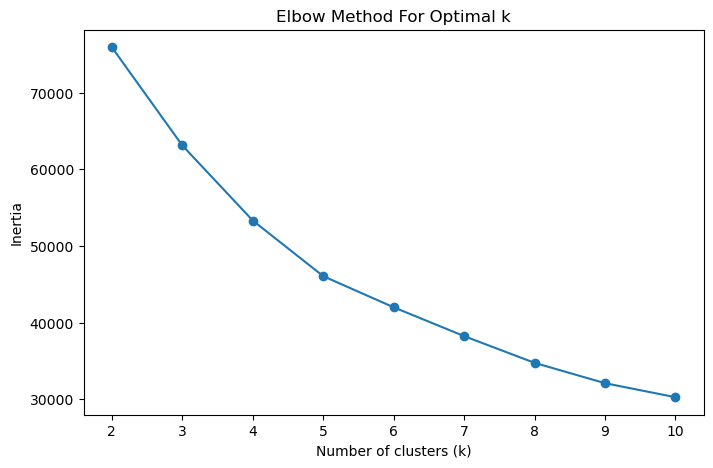

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(list(ks), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

In [31]:
gcamp_features_raw_active['cluster_2'] = models[2].labels_
gcamp_features_raw_active['cluster_3'] = models[3].labels_
gcamp_features_raw_active['cluster_4'] = models[4].labels_
gcamp_features_raw_active['cluster_5'] = models[5].labels_
gcamp_features_raw_active['cluster_6'] = models[6].labels_
gcamp_features_raw_active['cluster_7'] = models[7].labels_
gcamp_features_raw_active['cluster_8'] = models[8].labels_
gcamp_features_raw_active['cluster_9'] = models[9].labels_
gcamp_features_raw_active['cluster_10'] = models[10].labels_

# Peak Clustering Result without Inactive cells

In [35]:
df = gcamp_features_raw_active.copy()
mapping = {
    0: "multiple peaks (MP)",
    1: "plateau peak (PP)",
    2: "small peak (SP)",
    3: "moderate peak (MoP)",
    4: "high peak (HP)"
}
df["cluster_5_name"] = df["cluster_5"].map(mapping)
feature_cols = [
    'Median',
    'AUC_above_median',
    'Peak_Amplitude_fold',
    'Peak_Amplitude',
    'Peak_Duration'
]
k = 5
cluster_col = f"cluster_{k}"
grouped = df.groupby([cluster_col, "cluster_5_name"])

results = []
for (cluster_label, cluster_name), sub_df in grouped:
    row_dict = {}
    row_dict["cluster_label"] = cluster_label
    row_dict["cluster_name"] = cluster_name
    row_dict["n_cells"] = len(sub_df)
    #row_dict["peakcount>0"] = (sub_df['Peak_Counts'] > 0).sum()
    row_dict["peakcount>1"] = (sub_df['Peak_Counts'] > 1).sum()
    median_stats = sub_df[feature_cols].median()
    for feat in feature_cols:
        if feat == "AUC_above_median":
            row_dict["median_AUC"] = median_stats[feat]
        else:
            row_dict[f"median_{feat}"] = median_stats[feat]
    
    results.append(row_dict)
df_cluster5_summary = pd.DataFrame(results)
df_cluster5_summary.sort_values(by=["cluster_label", "cluster_name"], inplace=True)

df_cluster5_summary


,cluster_label,cluster_name,n_cells,peakcount>1,median_Median,median_AUC,median_Peak_Amplitude_fold,median_Peak_Amplitude,median_Peak_Duration
0,0,multiple peaks (MP),4370,4370,3.505297,16.942925,1.822625,2.747451,4.666667
1,1,plateau peak (PP),1270,69,4.058316,33.353554,2.352139,4.664720,17.000000
2,2,small peak (SP),8401,0,3.227818,9.361111,1.556701,1.859734,4.000000
3,3,moderate peak (MoP),3797,705,2.984085,29.779541,3.007609,5.634571,8.000000
4,4,high peak (HP),1036,333,4.126901,78.404347,4.366600,11.861016,10.000000


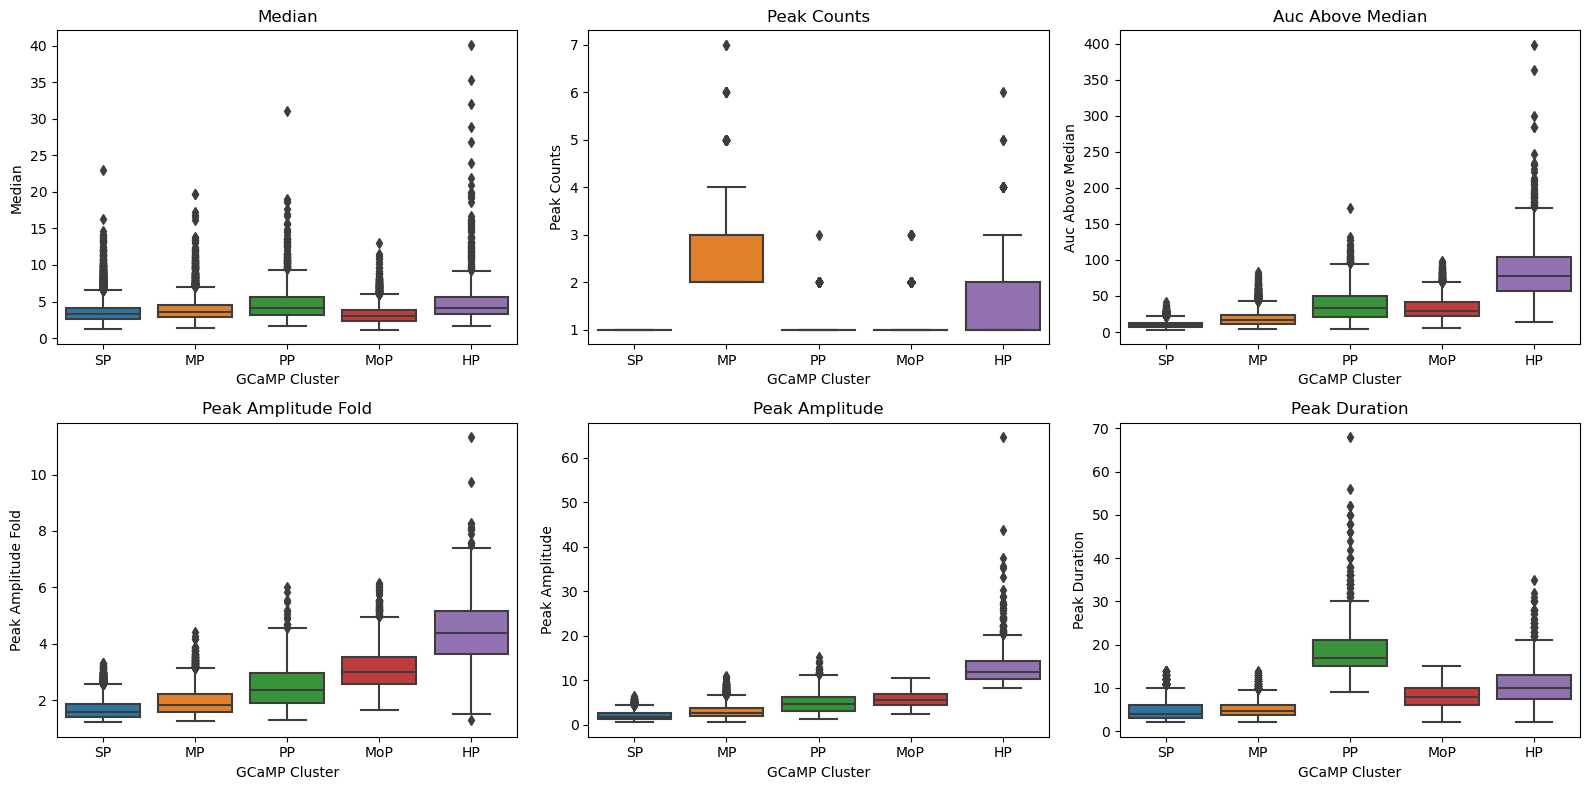

In [26]:
mapping_short = {
    0: 'MP',  # multiple peaks (MP)
    1: 'PP',  # plateau peak (PP)
    2: 'SP',  # small peak (SP)
    3: 'MoP', # moderate peak (MoP)
    4: 'HP'   # high peak (HP)
}
df = gcamp_features_raw_active.copy()  # rename for convenience
df['cluster_5_name_short'] = df['cluster_5'].map(mapping_short).astype(str)
cluster_order = ['SP', 'MP', 'PP', 'MoP','HP']
def prettify(name):
    return " ".join(word.capitalize() for word in name.split('_'))

features = [
    'Median',
    'Peak_Counts',
    'AUC_above_median',
    'Peak_Amplitude_fold',
    'Peak_Amplitude',
    'Peak_Duration'
]

plt.figure(figsize=(16, 8))
for i, feat in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='cluster_5_name_short', y=feat, order=cluster_order)
    plt.title(prettify(feat))
    plt.ylabel(prettify(feat))
    plt.xlabel("GCaMP Cluster")
plt.tight_layout()
plt.savefig("figure_3b.png", dpi=300, bbox_inches="tight")
plt.show()


In [30]:
custom_palette = {
    'Excitatory Neurons': '#44a843',
    'Inhibitory Neurons': '#9f78c3',
    'Neuronal Progenitors': '#9f7269',
    'NPC': '#e36d6f',
    'Radial Glia': '#e584c7',
    'Cycling Radial Glia': '#ff9c4c',
    'Astrocytes': '#3985bb',
    'Transitory Neural Cells': '#909394'
}

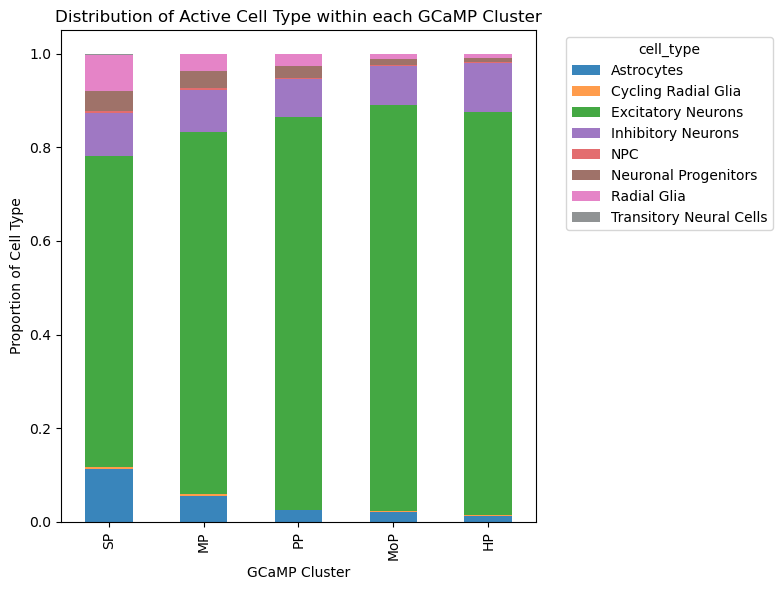

In [28]:
desired_order = ['SP', 'MP', 'PP', 'MoP', 'HP']
ct = pd.crosstab(
    gcamp_features_raw_active["cluster_5_name_short"],
    gcamp_features_raw_active["cell_type"],
    normalize="index"
)

# Reindex the rows to your desired order
ct = ct.reindex(desired_order)

colors = [custom_palette[cell_type] for cell_type in ct.columns]
ax = ct.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 6),
    color=colors
)

ax.set_xlabel("GCaMP Cluster")
ax.set_ylabel("Proportion of Cell Type")
ax.set_title("Distribution of Active Cell Type within each GCaMP Cluster")

plt.legend(title="cell_type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


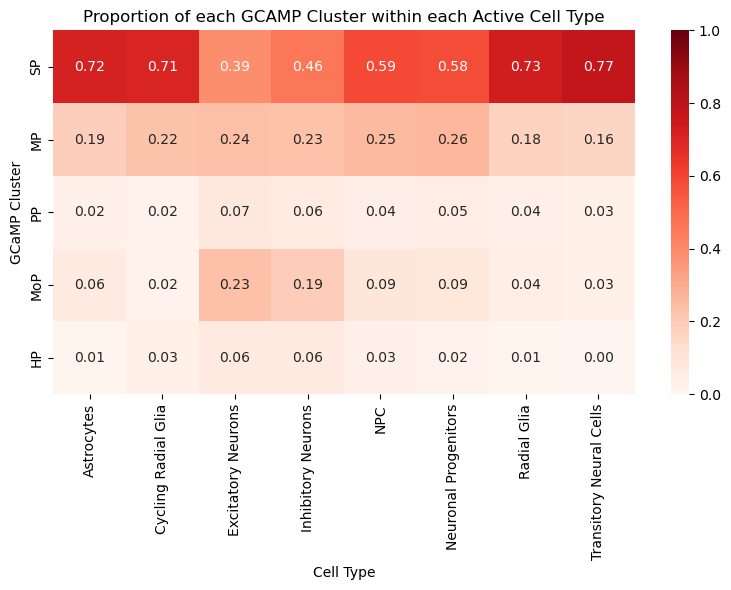

In [128]:
desired_order = ['SP', 'MP', 'PP', 'MoP', 'HP']

table = pd.crosstab(
    gcamp_features_raw_active["cluster_5_name_short"],
    gcamp_features_raw_active["cell_type"],
    normalize="columns"
)

table = table.reindex(desired_order)

plt.figure(figsize=(8, 6))
sns.heatmap(
    table, 
    annot=True,
    cmap="Reds", 
    fmt=".2f",
    vmin=0, vmax=1
)
plt.title("Proportion of each GCAMP Cluster within each Active Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("GCaMP Cluster")
plt.tight_layout()
plt.show()


# Peak Clustering Result with Inactive Cells

In [37]:
df_active_indexed = gcamp_features_raw_active.set_index("cell_id")
df_raw_indexed = gcamp_features_raw.set_index("cell_id")
series_cluster5 = df_active_indexed["cluster_5"].reindex(df_raw_indexed.index)
series_cluster5 = series_cluster5.fillna(-1)
series_cluster5 = series_cluster5.astype(int)
series_cluster5 = series_cluster5.astype("category")
gcamp_features_raw["gcamp_type"] = series_cluster5.values
gcamp_features_raw.reset_index(inplace=True)

In [40]:
mapping_1 = {
    -1:"Inactive (IA)",
    0: "Multiple Peaks (MP)",
    1: "Plateau Peak (PP)",
    2: "Small Peak (SP)",
    3: "Moderate Peak (MoP)",
    4: "High Peaks (HP)"
}
mapping_2 = {
    -1:"IA",
    0: "MP",
    1: "PP",
    2: "SP",
    3: "MoP",
    4: "HP"
}
mapping_3 = {
    -1:"Inactive",
    0: "Multiple Peaks",
    1: "Plateau Peak",
    2: "Small Peak",
    3: "Moderate Peak",
    4: "High Peaks"
}
gcamp_features_raw["gcamp_type_name"] = gcamp_features_raw["gcamp_type"].map(mapping_1).astype(str)
gcamp_features_raw["gcamp_type_name_short"] = gcamp_features_raw["gcamp_type"].map(mapping_2).astype(str)
gcamp_features_raw["gcamp_type_name_long"] = gcamp_features_raw["gcamp_type"].map(mapping_3).astype(str)


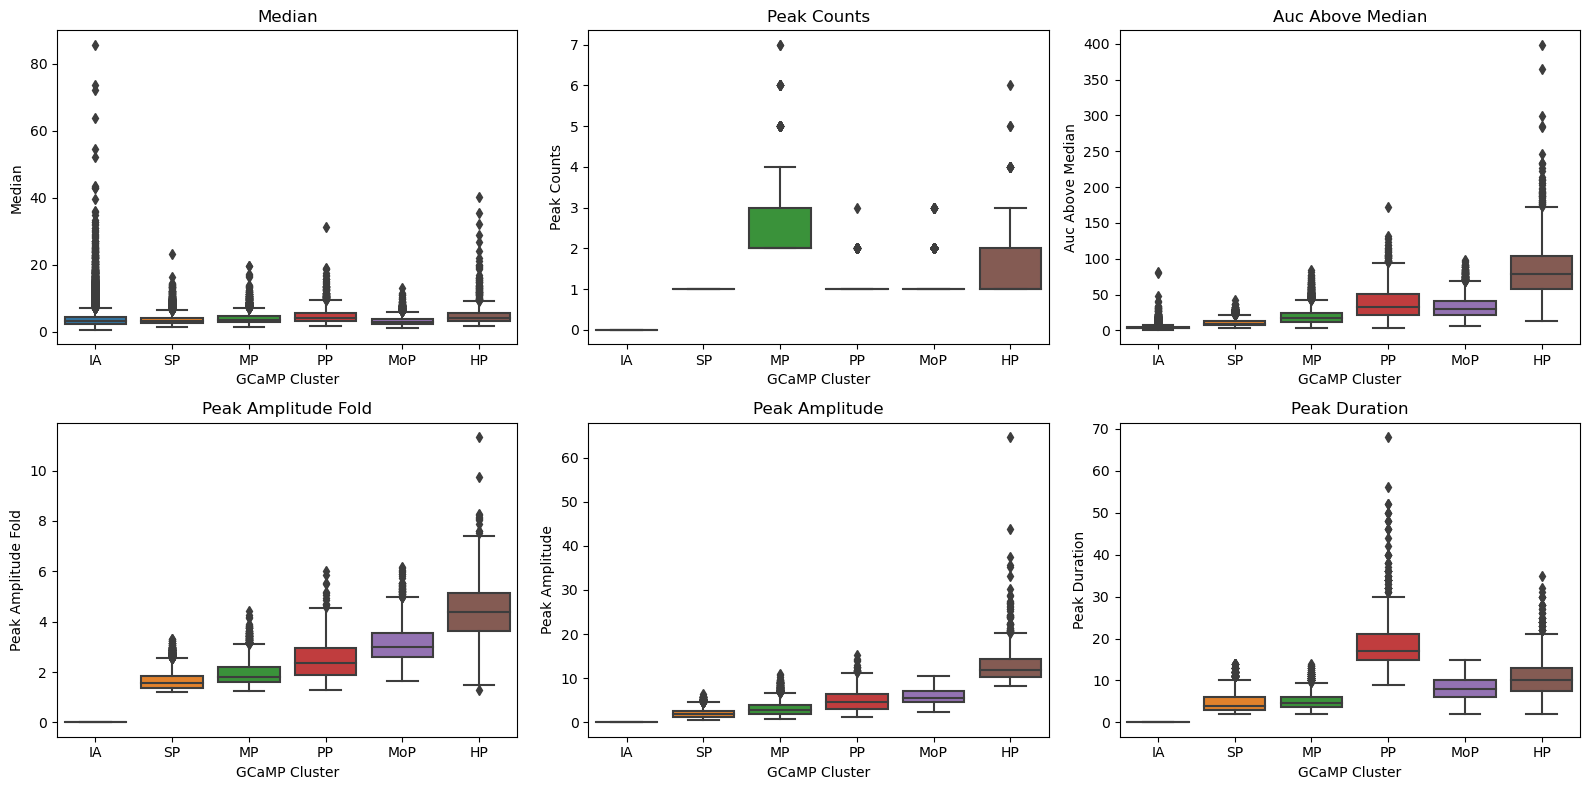

In [42]:
df = gcamp_features_raw.copy()
cluster_order = ['IA','SP', 'MP', 'PP', 'MoP', 'HP']
def prettify(name):
    return " ".join(word.capitalize() for word in name.split('_'))

features = [
    'Median',
    'Peak_Counts',
    'AUC_above_median',
    'Peak_Amplitude_fold',
    'Peak_Amplitude',
    'Peak_Duration'
]

plt.figure(figsize=(16, 8))
for i, feat in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='gcamp_type_name_short', y=feat, order=cluster_order)
    plt.title(prettify(feat))
    plt.ylabel(prettify(feat))
    plt.xlabel("GCaMP Cluster")
plt.tight_layout()
plt.show()


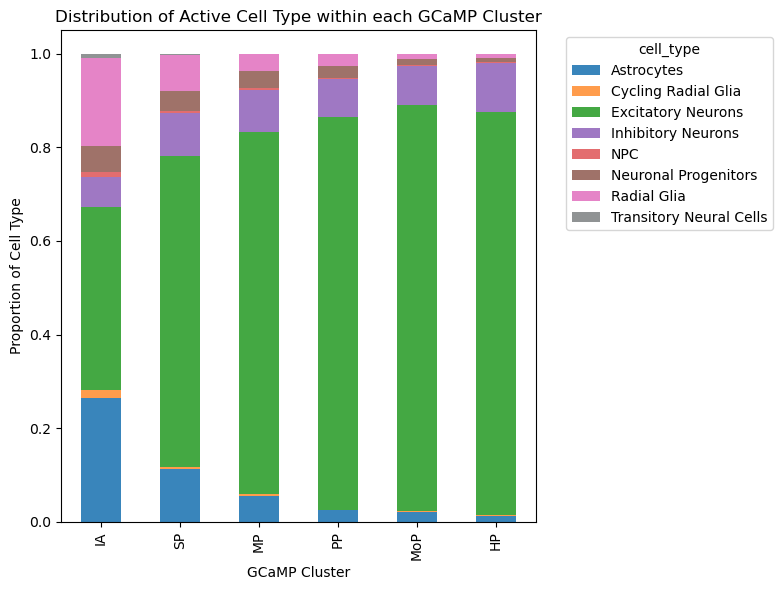

In [31]:
desired_order = ['IA','SP', 'MP', 'PP', 'MoP', 'HP']
ct = pd.crosstab(
    gcamp_features_raw["gcamp_type_name_short"],
    gcamp_features_raw["cell_type"],
    normalize="index"
)

ct = ct.reindex(desired_order)

colors = [custom_palette[cell_type] for cell_type in ct.columns]
ax = ct.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 6),
    color=colors
)

ax.set_xlabel("GCaMP Cluster")
ax.set_ylabel("Proportion of Cell Type")
ax.set_title("Distribution of Active Cell Type within each GCaMP Cluster")

plt.legend(title="cell_type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("figure_3d.png", dpi=300, bbox_inches="tight")
plt.show()


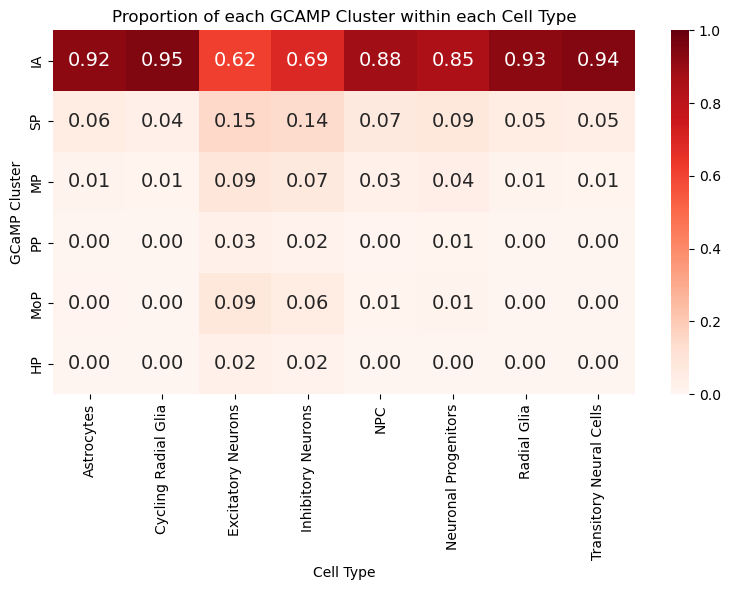

In [44]:
desired_order = ['IA','SP', 'MP', 'PP', 'MoP', 'HP']

table = pd.crosstab(
    gcamp_features_raw["gcamp_type_name_short"],
    gcamp_features_raw["cell_type"],
    normalize="columns"  # Each column sums to 1.0
)

# Reorder the rows to follow the desired order
table = table.reindex(desired_order)

plt.figure(figsize=(8, 6))
sns.heatmap(
    table, 
    annot=True,
    cmap="Reds", 
    fmt=".2f",
    annot_kws={"fontsize":14},
    vmin=0, vmax=1
)
plt.title("Proportion of each GCAMP Cluster within each Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("GCaMP Cluster")
plt.tight_layout()
plt.savefig("figure_3c.png", dpi=300, bbox_inches="tight")
plt.show()


# Signal Traces for different GCaMP cluster

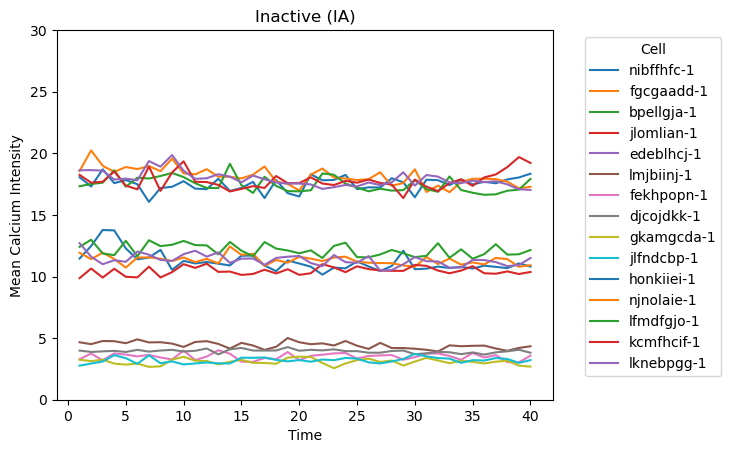

In [34]:
df_cluster_n1 = gcamp_features_raw[gcamp_features_raw['gcamp_type'] == -1]

df_in_17_20 = df_cluster_n1[(df_cluster_n1['Median'] >= 17) & (df_cluster_n1['Median'] <= 20)]
cell_id_list = df_in_17_20.sample(n=5, random_state=45)['cell_id'].tolist()
df_in_3_5 = df_cluster_n1[(df_cluster_n1['Median'] >= 3) & (df_cluster_n1['Median'] <= 5)]
cell_id_list = cell_id_list + df_in_3_5.sample(n=5, random_state=45)['cell_id'].tolist()
df_in_10_13 = df_cluster_n1[(df_cluster_n1['Median'] >= 10) & (df_cluster_n1['Median'] <= 13)]
cell_id_list = cell_id_list + df_in_10_13.sample(n=5, random_state=45)['cell_id'].tolist()

mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

plt.xlabel('Time')
plt.ylabel('Mean Calcium Intensity')
plt.title('Inactive (IA)')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 30)
plt.savefig("peaks_IA.png", dpi=300, bbox_inches="tight")
plt.show()

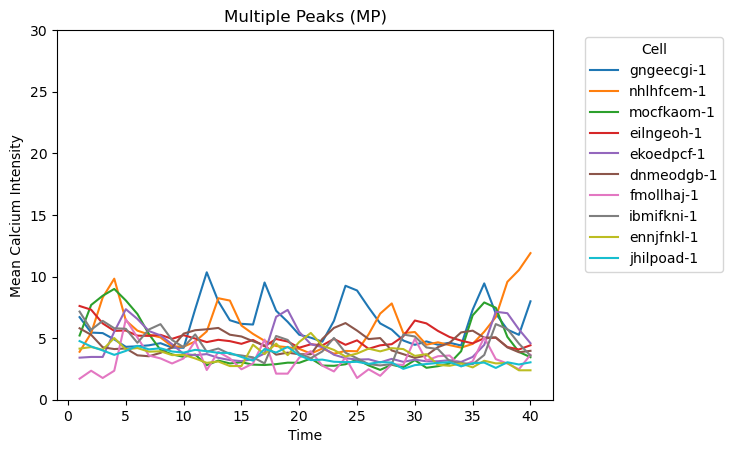

In [35]:
df_cluster_0 = gcamp_features_raw[gcamp_features_raw['gcamp_type'] == 0]

df_in_3 = df_cluster_0[(df_cluster_0['Peak_Counts'] >= 3)]
cell_id_list = df_in_3.sample(n=10, random_state=40)['cell_id'].tolist()

mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Mean Calcium Intensity')
plt.title('Multiple Peaks (MP)')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 30)
plt.savefig("peaks_MP.png", dpi=300, bbox_inches="tight")
plt.show()

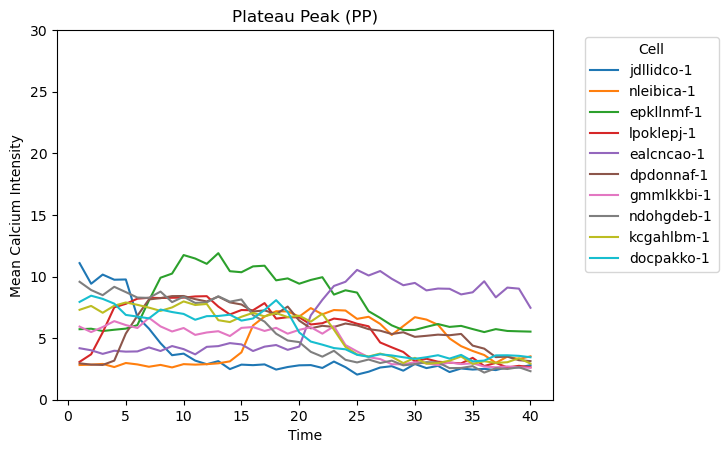

In [36]:
df_cluster_1 = gcamp_features_raw[gcamp_features_raw['gcamp_type'] == 1]

df_in_20_10 = df_cluster_1[(df_cluster_1['Peak_Duration'] >= 20) & (df_cluster_1['Peak_Amplitude'] <= 10)
                          & (df_cluster_1['Peak_Amplitude_fold'] >= 1.5)]
cell_id_list = df_in_20_10.sample(n=10, random_state=20)['cell_id'].tolist()

mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Mean Calcium Intensity')
plt.title('Plateau Peak (PP)')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 30)
plt.savefig("peaks_PP.png", dpi=300, bbox_inches="tight")
plt.show()

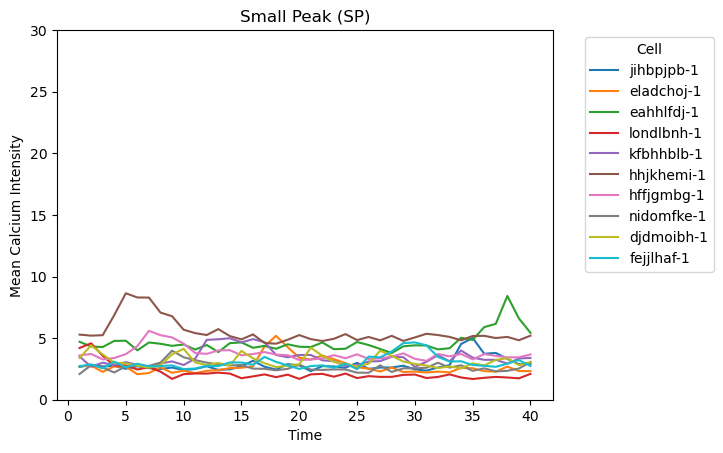

In [37]:
df_cluster_2 = gcamp_features_raw[gcamp_features_raw['gcamp_type'] == 2]

df_in_8_7 = df_cluster_2[(df_cluster_2['Peak_Duration'] <= 8) & (df_cluster_2['Peak_Amplitude'] <= 7)
                          & (df_cluster_2['Peak_Amplitude_fold'] >= 1.5)]
cell_id_list = df_in_8_7.sample(n=10, random_state=20)['cell_id'].tolist()

mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Mean Calcium Intensity')
plt.title('Small Peak (SP)')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 30)
plt.savefig("peaks_SP.png", dpi=300, bbox_inches="tight")
plt.show()

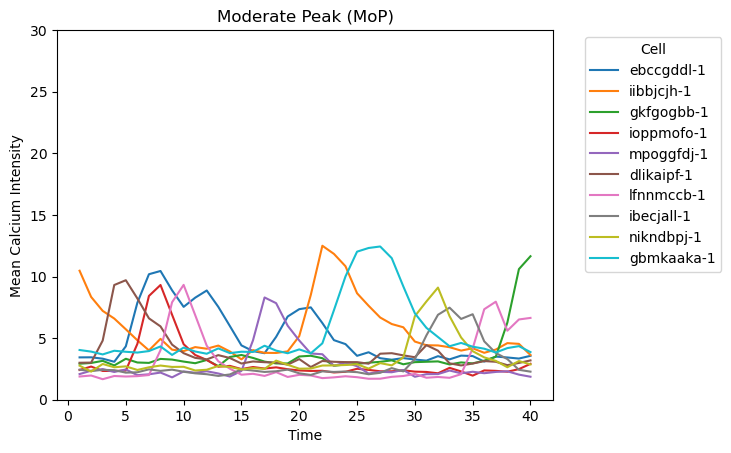

In [38]:
df_cluster_3 = gcamp_features_raw[gcamp_features_raw['gcamp_type'] == 3]

df_in_3_5 = df_cluster_3[(df_cluster_3['Peak_Duration'] <= 15) & (df_cluster_3['Peak_Amplitude_fold'] <= 6)
                          & (df_cluster_3['Peak_Amplitude_fold'] >= 3)]
cell_id_list = df_in_3_5.sample(n=10, random_state=45)['cell_id'].tolist()

mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Mean Calcium Intensity')
plt.title('Moderate Peak (MoP)')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 30)
plt.savefig("peaks_MoP.png", dpi=300, bbox_inches="tight")
plt.show()

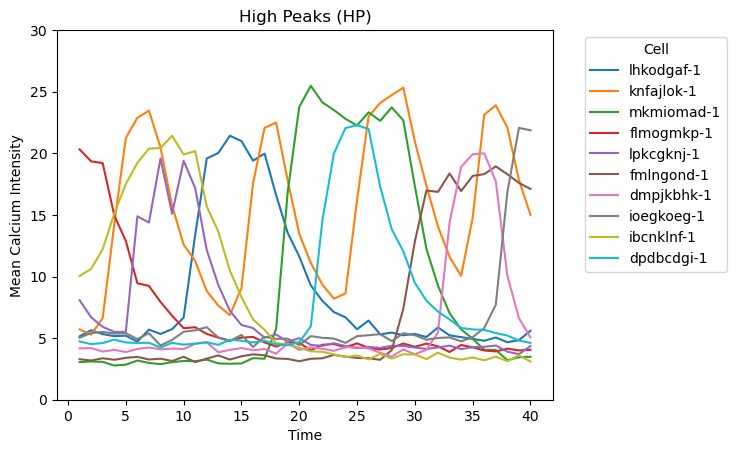

In [39]:
df_cluster_4 = gcamp_features_raw[gcamp_features_raw['gcamp_type'] == 4]

df_in_4_15 = df_cluster_4[(df_cluster_4['Peak_Duration'] <= 20) & (df_cluster_4['Peak_Amplitude_fold'] >= 4)
                          & (df_cluster_4['Peak_Amplitude'] >= 15)]
cell_id_list = df_in_4_15.sample(n=10, random_state=43)['cell_id'].tolist()

mean_intensities_np = adata_mean_intensities[:,cell_id_list].X
time_range = np.arange(1, 41)

for i in range(len(cell_id_list)):
    plt.plot(time_range, mean_intensities_np[:,i], label=f'{cell_id_list[i]}')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Mean Calcium Intensity')
plt.title('High Peaks (HP)')
plt.legend(title="Cell", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 30)
plt.savefig("peaks_HP.png", dpi=300, bbox_inches="tight")
plt.show()

# DEG

In [40]:
adata_with_gcamp = ad.read_h5ad("path/to/adata_gcamp.h5ad")

In [45]:
adata_with_gcamp.obs['gcamp_type'] = adata_with_gcamp.obs['gcamp_type'].astype('category')
ordered_categories = [-1] + [x for x in adata_with_gcamp.obs['gcamp_type'].cat.categories if x != -1]
mapping_short = {
    -1: "IA",   # Inactive cells
     0: "MP",  # multiple peaks
     1: "PP",  # plateau peak
     2: "SP",  # small peak
     3: "MoP", # moderate peak
     4: "HP"   # high peak
}
results_list = []
for group in ordered_categories[1:]:
    mask = adata_with_gcamp.obs['gcamp_type'].isin([group, -1])
    adata_subset = adata_with_gcamp[mask].copy()
    adata_subset.obs['comparison'] = adata_subset.obs['gcamp_type'].astype(str)
    sc.tl.rank_genes_groups(
        adata_subset, 
        groupby='comparison', 
        groups=[str(group)], 
        reference='-1', 
        method='t-test'
    )
    
    de_results = pd.DataFrame({
        'gene': adata_subset.uns['rank_genes_groups']['names'][str(group)],
        'logfoldchanges': adata_subset.uns['rank_genes_groups']['logfoldchanges'][str(group)],
        'pvals_adj': adata_subset.uns['rank_genes_groups']['pvals_adj'][str(group)]
    })
    
    de_results['Cluster'] = group
    de_results['gcamp_cluster_short'] = de_results['Cluster'].map(mapping_short)
    sig_results = de_results[(de_results['pvals_adj'] < 0.05) & (de_results['logfoldchanges'] > 1.5)].copy()
    results_list.append(sig_results)
final_results = pd.concat(results_list, ignore_index=True)


In [46]:
final_results

,gene,logfoldchanges,pvals_adj,Cluster,gcamp_cluster_short
0,FEV,1.530833,1.014223e-20,0,MP
1,SERPINB9,1.549278,2.501755e-14,0,MP
2,TPH2,1.895982,1.273583e-11,0,MP
3,RNF128,1.594821,8.231758e-11,0,MP
4,UTS2,2.512861,1.189310e-07,0,MP
...,...,...,...,...,...
78,CALCRL,1.575473,2.587229e-03,4,HP
79,EMX2,1.568772,4.636516e-03,4,HP
80,CACNG3,2.335748,5.989709e-03,4,HP
81,HTR1A,2.039452,9.961113e-03,4,HP


In [47]:
final_results['gcamp_cluster_short'].value_counts()

gcamp_cluster_short
HP     52
MoP    18
MP      6
PP      6
SP      1
Name: count, dtype: int64

In [48]:
df_HP = final_results[final_results['gcamp_cluster_short']=='HP'].sort_values('logfoldchanges', ascending=False).head(15)
df_MoP = final_results[final_results['gcamp_cluster_short']=='MoP'].sort_values('logfoldchanges', ascending=False).head(15)
df_pp = final_results[final_results['gcamp_cluster_short']=='PP'].sort_values('logfoldchanges', ascending=False)
df_MP = final_results[final_results['gcamp_cluster_short']=='MP'].sort_values('logfoldchanges', ascending=False)
selected_genes = list(df_HP['gene'])+list(df_MoP['gene'])+list(df_pp['gene'])+list(df_MP['gene'])

In [49]:
selected_genes = list(dict.fromkeys(selected_genes))

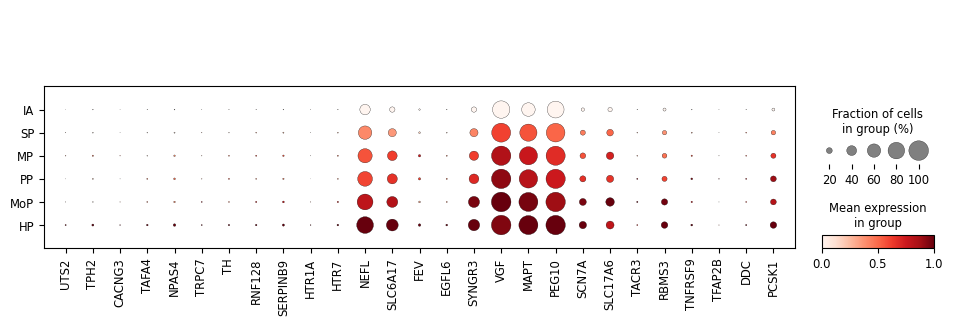

In [50]:
desired_order = ['IA','SP', 'MP', 'PP', 'MoP', 'HP']
adata_velocity.obs['gcamp_type_name_short'] = adata_velocity.obs['gcamp_type_name_short'].astype('category')
adata_velocity.obs['gcamp_type_name_short'] = adata_velocity.obs['gcamp_type_name_short'].cat.set_categories(desired_order, ordered=True)
sc.pl.dotplot(adata_velocity, var_names=selected_genes, groupby='gcamp_type_name_short', standard_scale='var',
             save="figure_3f.png")
